In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import Image
from scipy import stats
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

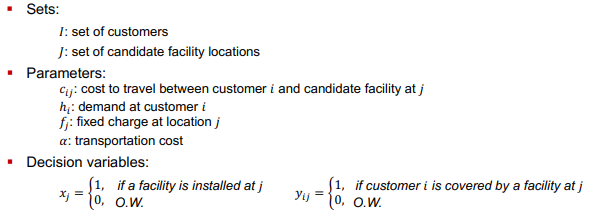

In [3]:
# display the variables
Image(filename='variables.png')

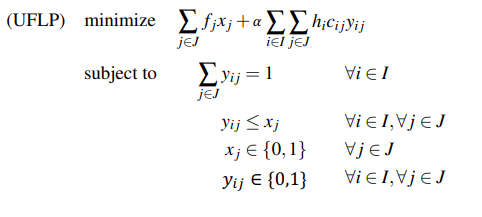

In [4]:
# display the model
Image(filename='model.png')

In [5]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
j_data = pd.read_excel('data.xlsx', sheet_name='j_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [6]:
# declare the parameters and sets
h = i_data['Demand'].values
f = j_data['Fixed Charge'].values

I = [i for i in range(len(h))]
J = [j for j in range(len(f))]
A = [(i, j) for i in I for j in J]

c = {(i, j): dist_ij[i, j] for (i, j) in A}

a = 0.3

In [7]:
# create model
mdl = Model('UFLP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [8]:
# add model variables
x = mdl.addVars(J, vtype=GRB.BINARY)
y = mdl.addVars(A, vtype=GRB.BINARY)

In [9]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(f[j]*x[j] for j in J) + a * quicksum(h[i]*c[i,j]*y[i,j] for i,j in A))

In [10]:
# add the model constraints
mdl.addConstrs(quicksum(y[i,j] for j in J) == 1 for i in I)
mdl.addConstrs(y[i,j] <= x[j] for i,j in A)
mdl.update()

In [11]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2100 rows, 2020 columns and 6000 nonzeros
Model fingerprint: 0xd4a6270a
Variable types: 0 continuous, 2020 integer (2020 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+02, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 350594.48576
Presolve time: 0.01s
Presolved: 2100 rows, 2020 columns, 6000 nonzeros
Variable types: 0 continuous, 2020 integer (2020 binary)

Root relaxation: objective 1.684479e+05, 431 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    168447.87653 168447.877  0.00%     -    0s

Explored 0 nodes (431 simplex iterations) in 0.02 seconds
Thread count was 16 (o

In [12]:
# opened locations and covered customers
opened = [j for j in J if x[j].X > 0.0]
covered = [a for a in A if y[a].X > 0.0]

In [13]:
# update the dataframes
i_data['Covered'] = [a[1] for a in A if y[a].X > 0.0]
j_data['Opened'] = [int(x[j].X > 0.0) for j in J]

Text(0.5, 1.0, 'Stations Chosen')

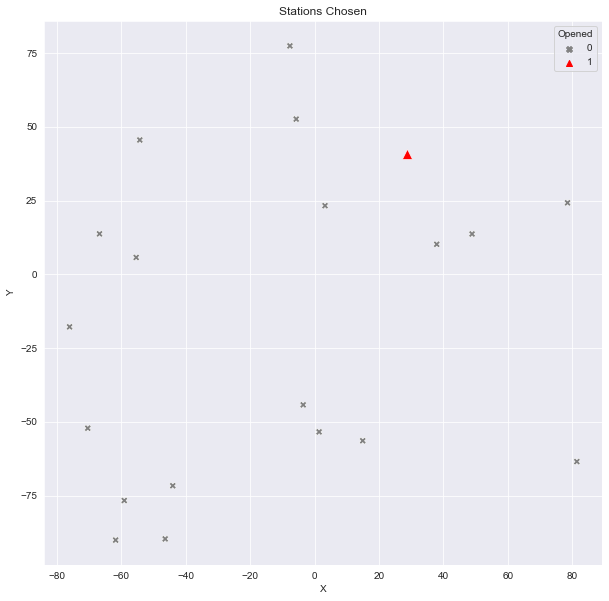

In [14]:
# plot the station locations
fig, ax = plt.subplots(figsize=(10,10))
s = [100 if i == 1 else 50 for i in j_data['Opened'].values]
sns.scatterplot(
    x='X', y='Y', data=j_data, 
    hue='Opened', palette=['grey', 'red'], 
    style='Opened', markers=('X', '^'), s=s
)
plt.title('Stations Chosen')

Text(0.5, 1.0, 'Facility Coverage')

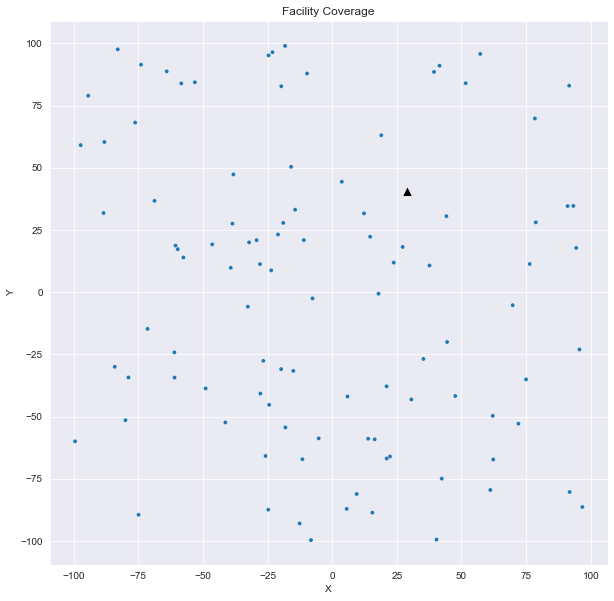

In [15]:
# plot the customer coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=i_data, hue='Covered', palette='tab20', size=1, legend=False)
sns.scatterplot(x='X', y='Y', data=j_data[j_data['Opened'] == 1], s=100, color='black', marker='^')
plt.title('Facility Coverage')

In [16]:
# find objective value
fac_cost = sum([f[j]*x[j].X for j in J])
trans_cost = sum([h[i] * c[i,j] for i,j in covered])
obj_val = fac_cost + a * trans_cost

print('Facility cost = ', fac_cost)
print('Transportation cost = ', trans_cost)
print('Objective value = ', obj_val)

Facility cost =  8379.772114834474
Transportation cost =  533560.3480534222
Objective value =  168447.87653086113
